#### Cleaning data and filtering the covid period

In [16]:
import pandas as pd
import numpy as np
import rolling_hrp as rol
import HRP
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel("data/ibrx_mensal.xlsx", na_values="-")

# transforming the 'Data' column to a date format
df['Data'] = df['Data'].str.replace('Jan', '01').str.replace('Fev', '02').str.replace('Mar', '03').str.replace('Abr', '04').str.replace('Mai', '05').str.replace('Jun', '06').str.replace('Jul', '07').str.replace('Ago', '08').str.replace('Set', '09').str.replace('Out', '10').str.replace('Nov', '11').str.replace('Dez', '12')
    
def filter_covid(df):
    
    df['Data'] = pd.to_datetime(df['Data'], format='%m-%Y')
    df_covid = df[(df['Data'] >= '2000-01-01') & (df['Data'] <= '2022-06-01')].dropna(axis=1) # dataframe with covid period include
    df_w_covid = df[(df['Data'] >= '2000-01-01') & (df['Data'] <= '2020-02-01')].dropna(axis=1) # dataframe with covid period excluded

    return [df_covid, df_w_covid]


data = filter_covid(df)

In [17]:
series_data = pd.DataFrame() # Create an empty dataframe to store the results
for i, j in enumerate(data):
    temp_stats = j.describe(percentiles=[0.25, 0.5, 0.75])
    temp_stats.loc['std'] = j.std() # Add standard deviation
    temp_stats.loc['skewness'] = j.skew() # Add skewness
    temp_stats.loc['kurtosis'] = j.kurtosis() # Add kurtosis
    series_data = pd.concat([series_data, temp_stats], axis=1) # Concatenate the results for each dataframe horizontally with the previous results
series_data = series_data[series_data.index.isin(['count', 'mean', 'std','min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis'])].T

series_data.to_csv('data/desc_stats.csv')
series_data

C:\Users\felip\AppData\Local\Temp\ipykernel_24336\900245486.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_stats.loc['skewness'] = j.skew() # Add skewness
C:\Users\felip\AppData\Local\Temp\ipykernel_24336\900245486.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_stats.loc['kurtosis'] = j.kurtosis() # Add kurtosis
C:\Users\felip\AppData\Local\Temp\ipykernel_24336\900245486.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_stats.loc['skewness'] = j.skew() # Add 

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
ALPA4,270.0,2.501244,11.064304,-38.943894,-4.476264,1.960298,8.541899,44.652981,0.051084,1.202992
ABEV3,270.0,1.766507,7.828494,-39.285136,-2.696130,1.911069,6.017561,30.846838,-0.269638,3.362001
BBDC3,270.0,1.685431,9.667875,-31.030564,-4.788686,1.119226,7.245883,35.732992,0.398518,0.651288
BBDC4,270.0,1.692227,9.832023,-31.926808,-4.510553,0.907931,8.054829,30.424833,0.189606,0.452099
BBAS3,270.0,2.140531,11.978648,-40.182422,-4.609942,1.090468,9.405603,47.543975,0.168598,1.611265
BRKM5,270.0,1.789163,13.424214,-35.961324,-7.167631,0.168634,10.305695,57.672451,0.575106,1.087512
CMIG4,270.0,1.633314,10.626790,-36.174785,-4.779176,1.779988,7.800991,54.050279,0.367049,2.605696
CPLE6,270.0,1.406455,9.957783,-33.734939,-4.802310,1.714520,7.540635,28.677014,0.011803,0.262513
ELET3,270.0,1.679600,14.480477,-32.959640,-7.226539,-0.352004,8.568001,60.500000,0.853939,1.939181
ELET6,270.0,1.692803,12.986689,-40.247678,-6.244666,0.917495,9.564325,44.479943,0.421676,1.243592


#### Applying HRP strategies to the data

In [18]:
def apply_rolling_hrp(df, window_length):
    df_result = df.iloc[:, 1:] # skipping the 'Data' column
    df_result = rol.rolling_window_HRP(df_result, window_length)
    df_result = df_result.reset_index(drop=True)
    df_result['Date'] = df['Data'].reset_index(drop=True)
    return df_result

def apply_hrp(lst):
    df_covid, df_w_covid = lst
    results_60c = apply_rolling_hrp(df_covid, 60)
    results_120c = apply_rolling_hrp(df_covid, 120)
    results_60 = apply_rolling_hrp(df_w_covid, 60)
    results_120 = apply_rolling_hrp(df_w_covid, 120)
    return [results_60c, results_120c, results_60, results_120]

data_hrp = apply_hrp(data)
data_hrp

c:\Users\felip\OneDrive\Área de Trabalho\python\BDAQ\HRP.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)
c:\Users\felip\OneDrive\Área de Trabalho\python\BDAQ\HRP.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)
c:\Users\felip\OneDrive\Área de Trabalho\python\BDAQ\HRP.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)
c:\Users\felip\OneDrive\Área de Trabalho\python\BDAQ\HRP.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distan

[          Date  Equal Weights        HRP         MV
 0   2000-01-01      -5.999268  -4.994623  -8.396179
 1   2000-02-01      15.019031  13.874689  14.817926
 2   2000-03-01      -6.380284  -7.403602  -5.429452
 3   2000-04-01      -6.549963  -9.712360 -19.441430
 4   2000-05-01       3.881629   2.924667   4.257075
 ..         ...            ...        ...        ...
 205 2017-02-01      -1.652292   0.448585  12.982208
 206 2017-03-01       5.879145   6.097339  12.537133
 207 2017-04-01      -5.814921  -4.902861  -5.778758
 208 2017-05-01       4.785115   2.607822  -3.600660
 209 2017-06-01     -11.232585 -10.157473  -7.850752
 
 [210 rows x 4 columns],
           Date  Equal Weights       HRP        MV
 0   2000-01-01      -2.882625 -2.872329 -0.749151
 1   2000-02-01      -0.228344 -0.342668 -3.188452
 2   2000-03-01       4.792239  3.412342 -1.389152
 3   2000-04-01      -2.560399 -1.488646  2.485828
 4   2000-05-01      -6.137683 -5.794305  1.258568
 ..         ...            ... 

In [19]:
names = ['60c', '120c', '60', '120']

for i, df in enumerate(data_hrp):
    df.to_csv(f'data/rolling_hrp_{names[i]}.csv', index=False)

c:\Users\felip\OneDrive\Área de Trabalho\python\BDAQ\HRP.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = linkage(euclidean_distance, method=linkage_method)


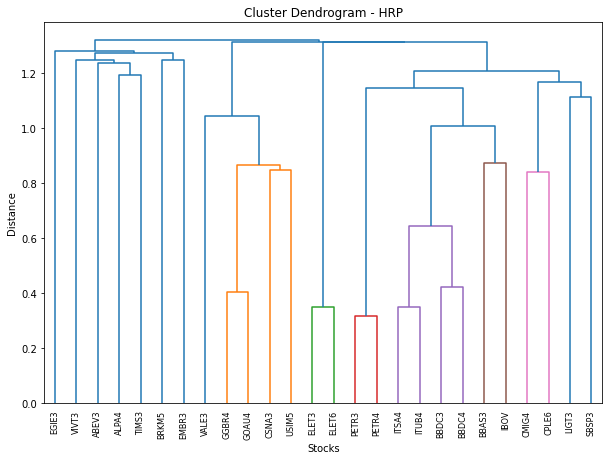

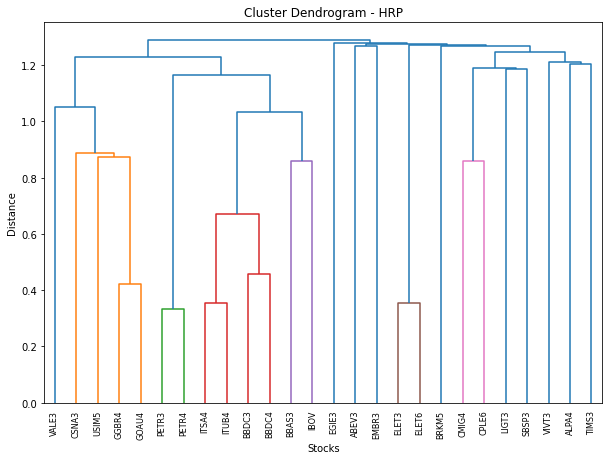

In [20]:
for i in data:
    weights = HRP.HRP_Portfolio(i.iloc[:, 1:], graph=True)


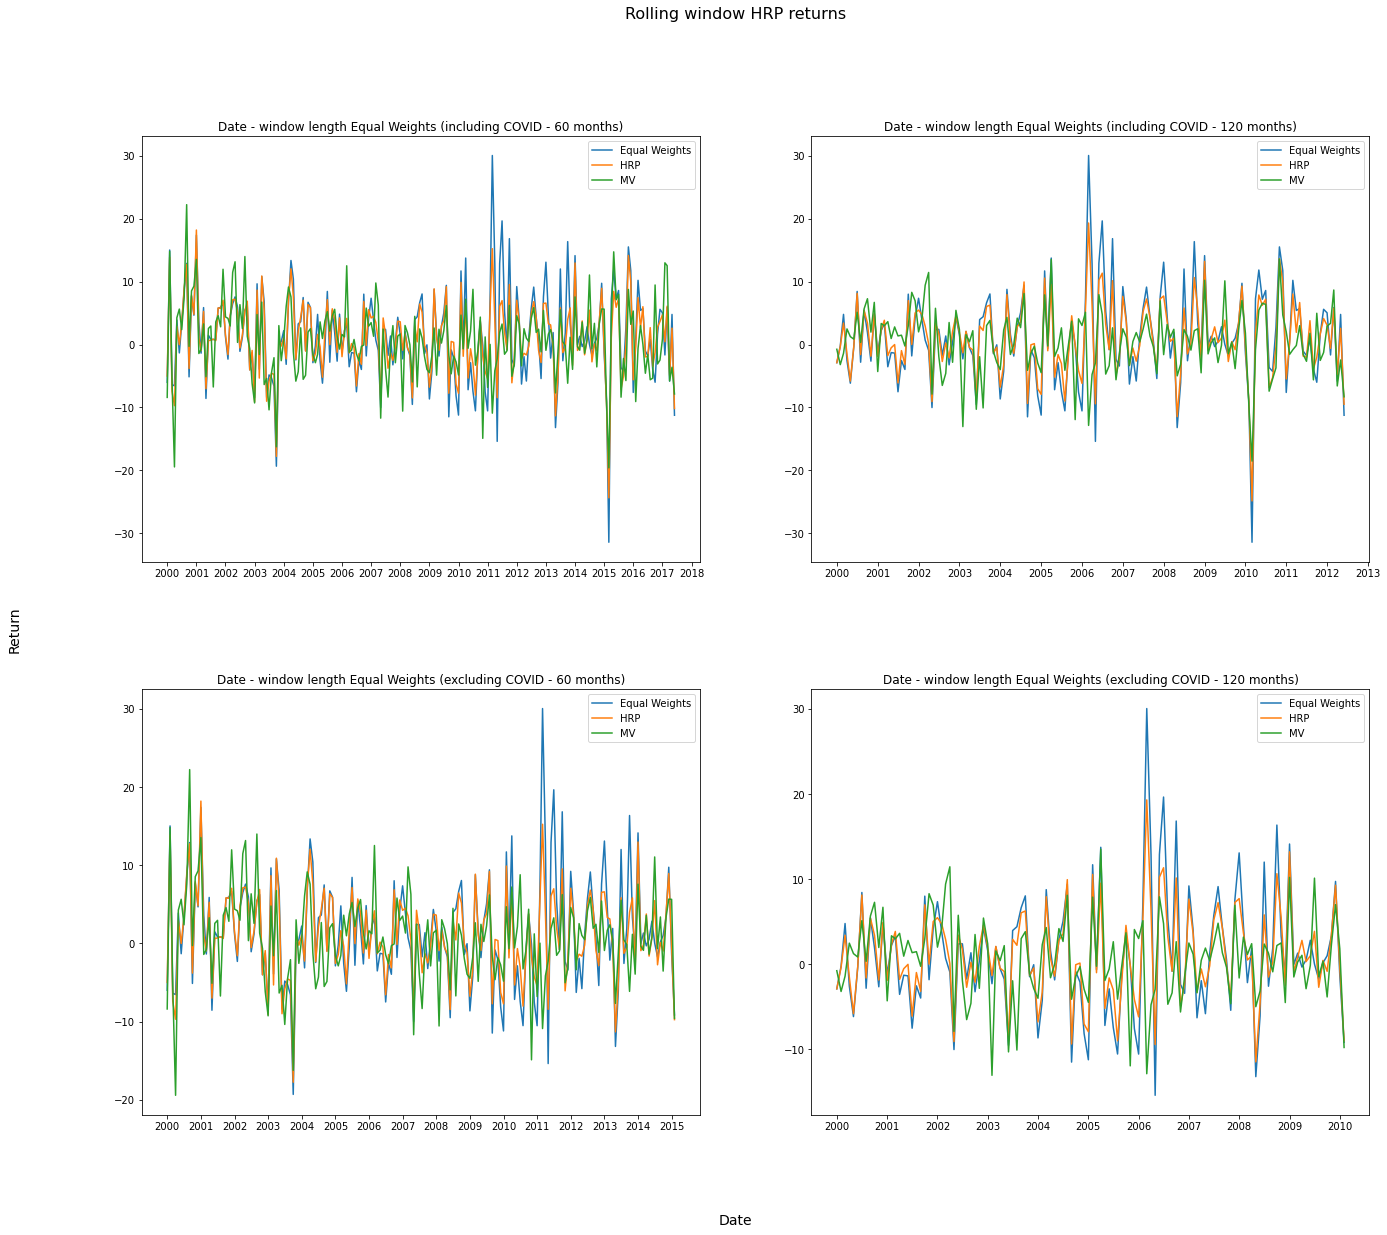

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a figure with four subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(22, 18))

# Set a title for the whole figure
fig.suptitle('Rolling window HRP returns', fontsize=16)

# Plot the returns for each strategy in each subplot
for i, j in enumerate(data_hrp):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    title = f"{j.columns[0]} - window length {j.columns[1]}"
    if i == 0:
        title += " (including COVID - 60 months)"
    elif i == 1:
        title += " (including COVID - 120 months)"
    elif i == 2:
        title += " (excluding COVID - 60 months)"
    else:
        title += " (excluding COVID - 120 months)"
    ax.set_title(title)
    for col_name in j.columns[1:]:
        ax.plot(j['Date'], j[col_name], label=col_name)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set common x and y axis labels
fig.text(0.5, 0.04, 'Date', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Return', va='center', rotation='vertical', fontsize=14)

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plt.show()


#### Adding descriptive statistics and concatenating the data to each strategy

In [22]:
stats = pd.DataFrame() # Create an empty dataframe to store the results
df_names = ["60c", "120c", "60", "120"]
for i, j in enumerate(data):
    temp_stats = j.describe(percentiles=[0.25, 0.5, 0.75])
    temp_stats.loc['std'] = j.std() # Add standard deviation
    temp_stats.loc['skewness'] = j.skew() # Add skewness
    temp_stats.loc['kurtosis'] = j.kurtosis() # Add kurtosis
    col_prefix = df_names[i] + "_" # Add prefix based on the original dataframe name
    temp_stats.columns = [col_prefix + col for col in temp_stats.columns] # Add prefix to column names
    stats = pd.concat([stats, temp_stats], axis=1) # Concatenate the results for each dataframe horizontally with the previous results
stats = stats[stats.index.isin(['count', 'mean', 'std','min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis'])].T

stats.to_csv('data/stats.csv')
stats

C:\Users\felip\AppData\Local\Temp\ipykernel_24336\652467639.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_stats.loc['skewness'] = j.skew() # Add skewness
C:\Users\felip\AppData\Local\Temp\ipykernel_24336\652467639.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_stats.loc['kurtosis'] = j.kurtosis() # Add kurtosis
C:\Users\felip\AppData\Local\Temp\ipykernel_24336\652467639.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_stats.loc['skewness'] = j.skew() # Add 

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
60c_ALPA4,270.0,2.501244,11.064304,-38.943894,-4.476264,1.960298,8.541899,44.652981,0.051084,1.202992
60c_ABEV3,270.0,1.766507,7.828494,-39.285136,-2.696130,1.911069,6.017561,30.846838,-0.269638,3.362001
60c_BBDC3,270.0,1.685431,9.667875,-31.030564,-4.788686,1.119226,7.245883,35.732992,0.398518,0.651288
60c_BBDC4,270.0,1.692227,9.832023,-31.926808,-4.510553,0.907931,8.054829,30.424833,0.189606,0.452099
60c_BBAS3,270.0,2.140531,11.978648,-40.182422,-4.609942,1.090468,9.405603,47.543975,0.168598,1.611265
60c_BRKM5,270.0,1.789163,13.424214,-35.961324,-7.167631,0.168634,10.305695,57.672451,0.575106,1.087512
60c_CMIG4,270.0,1.633314,10.626790,-36.174785,-4.779176,1.779988,7.800991,54.050279,0.367049,2.605696
60c_CPLE6,270.0,1.406455,9.957783,-33.734939,-4.802310,1.714520,7.540635,28.677014,0.011803,0.262513
60c_ELET3,270.0,1.679600,14.480477,-32.959640,-7.226539,-0.352004,8.568001,60.500000,0.853939,1.939181
60c_ELET6,270.0,1.692803,12.986689,-40.247678,-6.244666,0.917495,9.564325,44.479943,0.421676,1.243592


In [23]:
stats.to_csv("data/stats.csv")

#### Plotting correlation heatmap to each strategy

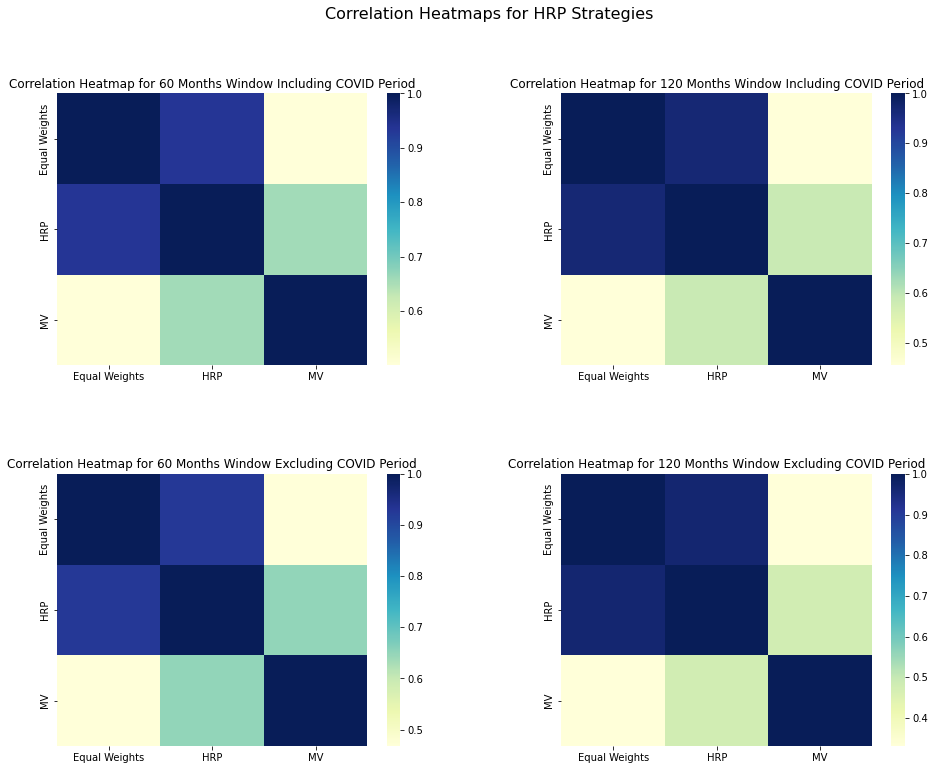

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `data_hrp` contains the four dataframes that you want to plot

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for i, j in enumerate(data_hrp):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    sns.heatmap(j.corr(), cmap="YlGnBu", ax=ax)
    if i == 0:
        ax.set_title("Correlation Heatmap for 60 Months Window Including COVID Period")
    elif i == 1:
        ax.set_title("Correlation Heatmap for 120 Months Window Including COVID Period")
    elif i == 2:
        ax.set_title("Correlation Heatmap for 60 Months Window Excluding COVID Period")
    else:
        ax.set_title("Correlation Heatmap for 120 Months Window Excluding COVID Period")

# Set common figure title
fig.suptitle('Correlation Heatmaps for HRP Strategies', fontsize=16)

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.3)

plt.show()


#### Plotting the correlation heatmap to each pair of assets

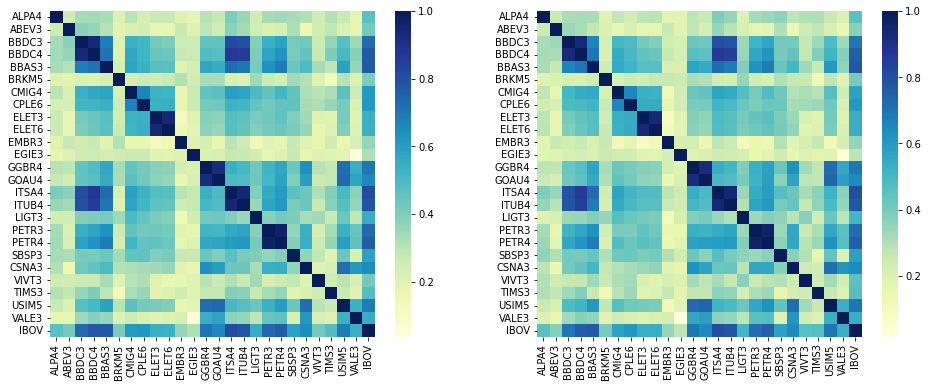

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i, j in enumerate(data):
    # if j.equals(data[0]):
    #     axs[i].set_title(f"Correlation Heatmap for Assets (including COVID period)")
    # else:
    #     axs[i].set_title(f"Correlation Heatmap for Assets (excluding COVID period)")
    sns.heatmap(j.corr(), cmap="YlGnBu", ax=axs[i])

plt.show()


In [26]:
for i, j in enumerate(data):
    if j.equals(data[0]):
        file_name = f"data\corr_matrix_including_covid.csv"
    else:
        file_name = f"data\corr_matrix_excluding_covid.csv"
        
    corr_matrix = j.corr()
    corr_matrix.to_csv(file_name)


#### More descriptive statistics to each asset. Note that the max column does not consider the comparison between the asset and itself

In [27]:
results_covid = pd.DataFrame()
results_wo_covid = pd.DataFrame()

for i, j in enumerate(data):
    if j.equals(data[0]):
        prefix = 'covid_'
    else:
        prefix = 'wo_covid_'
    
    corr_matrix = j.corr()
    results = pd.DataFrame(index=corr_matrix.index, columns=[f'{prefix}min', f'{prefix}max', f'{prefix}mean', f'{prefix}sd'])
    
    for asset in corr_matrix.columns:
        results.loc[asset, f'{prefix}min'] = corr_matrix[asset].min()
        results.loc[asset, f'{prefix}max'] = corr_matrix[asset][corr_matrix[asset] < 1].max()
        results.loc[asset, f'{prefix}mean'] = corr_matrix[asset].mean()
        results.loc[asset, f'{prefix}sd'] = corr_matrix[asset].std()
    
    if i == 0:
        results_covid = results
    else:
        results_wo_covid = results
    
results_concat = pd.concat([results_covid, results_wo_covid], axis=1)
results_concat


,covid_min,covid_max,covid_mean,covid_sd,wo_covid_min,wo_covid_max,wo_covid_mean,wo_covid_sd
ALPA4,0.180348,0.467619,0.320694,0.153167,0.170371,0.454753,0.309944,0.156106
ABEV3,0.159815,0.4144,0.29267,0.159986,0.146747,0.373675,0.264593,0.163197
BBDC3,0.217331,0.939455,0.498983,0.210811,0.212054,0.930972,0.477464,0.214255
BBDC4,0.210637,0.939455,0.521173,0.217712,0.207087,0.930972,0.504095,0.221847
BBAS3,0.197934,0.773849,0.511582,0.197521,0.20087,0.770689,0.501014,0.200654
BRKM5,0.126099,0.402946,0.286736,0.157884,0.121283,0.396867,0.274911,0.157905
CMIG4,0.174087,0.67136,0.457422,0.177649,0.130151,0.651366,0.431512,0.184449
CPLE6,0.174159,0.67136,0.439464,0.173666,0.165105,0.651366,0.421973,0.175769
ELET3,0.118086,0.94124,0.409911,0.205428,0.085753,0.938107,0.403645,0.210201
ELET6,0.153404,0.94124,0.406705,0.202997,0.121475,0.938107,0.402664,0.206967


In [28]:
results_concat.to_csv("data/basic_stats.csv")

#### Metrics

In [29]:
# removing date
data_hrp_w_date = []

for i in range(len(data_hrp)):
    df_result = data_hrp[i].iloc[:, 1:] # skipping the 'Data' column
    data_hrp_w_date.append(df_result)

# Define helper functions for calculating metrics
def annualize_return(return_series):
    return (1 + return_series.mean()) ** 12 - 1

def annualize_std(return_series):
    return return_series.std() * np.sqrt(12)

def sharpe_ratio(return_series, risk_free_rate):
    excess_return = return_series - risk_free_rate
    return np.sqrt(12) * excess_return.mean() / excess_return.std()

def adjusted_sharpe_ratio(return_series, risk_free_rate, factor_loadings):
    excess_return = return_series - risk_free_rate
    denominator = np.sqrt(12 * (1 + (factor_loadings ** 2).sum()))
    return (np.sqrt(12) * excess_return.mean() / excess_return.std()) / denominator

def sortino_ratio(return_series, risk_free_rate):
    downside_returns = return_series - risk_free_rate
    downside_std = downside_returns[downside_returns < 0].std() * np.sqrt(12)
    return np.sqrt(12) * (return_series.mean() - risk_free_rate) / downside_std

In [30]:
# Define parameters
risk_free_rate = 0.1375 # annualized SELIC for march 2023
factor_loadings = np.array([0.5, 0.3, 0.2])  # Assuming 3 factors

# Define output DataFrame
results = pd.DataFrame()

# Loop over each dataframe in data_hrp_w_date and calculate metrics
for i in range(len(data_hrp_w_date)):
    if i == 0:
        name = '60m_covid'
    elif i == 1:
        name = '120m_covid'
    elif i == 2:
        name = '60m_wo_covid'
    else:
        name = '120m_wo_covid'
    
    # Calculate metrics for each column (assuming returns are already in decimal form)
    df = data_hrp_w_date[i]
    av = df.mean() * 12
    sd = df.std() * np.sqrt(12)
    sr = sharpe_ratio(df, risk_free_rate)
    asr = adjusted_sharpe_ratio(df, risk_free_rate, factor_loadings)
    sor = sortino_ratio(df, risk_free_rate)
    to = (np.abs(df.diff()).sum() / 2) / df.shape[0]
    ssw = (df ** 2).sum() / df.shape[0]
    
    # Combine results into a single row for this dataframe
    row = pd.DataFrame({
        f'{name}_AV': av,
        f'{name}_SD': sd,
        f'{name}_SR': sr,
        f'{name}_ASR': asr,
        f'{name}_SoR': sor,
        f'{name}_TO': to,
        f'{name}_SSW': ssw
    })
    
    # Append row to results dataframe
    results = pd.concat([results, row], axis=1)


In [31]:
results = results.rename_axis('metric').reset_index()
results_transposed = results.T
results_transposed.columns = results_transposed.iloc[0]
results_transposed = results_transposed.iloc[1:]
results_transposed.to_csv("data/metrics.csv")
